In [60]:
from pathlib import Path
import sys
import torch
import time
from src.agent_interaction import ENV2048
import training_simple
import training_every_action 
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
import numpy as np


In [80]:
def plot_results(rewards, top_square, moves):
    """ Plots results of games"""
    matplotlib.rc('font', size=20) 
    fig, ax = plt.subplots(1, 3, figsize = (33, 11))
    for i in range(3):
        ax[i].set_xlabel("Run")
    ax[0].scatter(range(len(rewards)), rewards)
    ax[0].set_ylabel("Final Reward")
    ax[0].set_title("Rewards")
    ax[1].scatter(range(len(moves)), moves)
    ax[1].set_ylabel("# of Moves")
    ax[1].set_title("Moves")
    ax[2].scatter(range(len(top_square)), top_square)
    ax[2].set_yscale('log', base=2)
    ax[2].set_ylabel("Top Square Value")
    ax[2].set_title("Top Squares")
    
def summarize_results(rewards, top_square, moves):
    rewards = np.array(rewards)
    top_square = np.array(top_square)
    moves = np.array(moves)
    
    # counts
    u, c = np.unique(top_square, return_counts=True)
    
    return {"Rewards": {"mean": rewards.mean(),
                        "std": rewards.std(),
                        "min": rewards.min(),
                        "max": rewards.max()},
            "Top Square": {"min": top_square.min(),
                           "max": top_square.max(),
                           "counts": list(zip(u, c)) },
            "Moves": {"mean": moves.mean(),
                        "std": moves.std(),
                        "min": moves.min(),
                        "max": moves.max()}
    }
    
def format_results(results):
    for i in ['Rewards', 'Moves']:
        print(i)
        print("---------------")
        print(f"Mean | {results[i]['mean']}")
        print(f"STD  | {results[i]['std']}")
        print(f"Max  | {results[i]['max']}")
        print(f"Min  | {results[i]['min']}")
        print("---------------")
        print()
    print("Top Squares")
    print("---------------")
    print(f"Min  | {results['Top Square']['min']}")
    print(f"Max  | {results['Top Square']['max']}")
    print(f"Counts:")
    for u, c in results['Top Square']['counts']:
        print(f"\t{u:5} | {c}")

    
    

In [98]:
def play_game(dqn_file, model_cls, runs = 1000):
    """ Plays game for a number of runs"""
    # dqn path
    dqn = Path(dqn_file)

    # device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # load model
    model = model_cls(16, 4, None)
    model.load_state_dict(torch.load(str(dqn / 'model_weights.pt'), map_location=device))
    model = model.to(device)

    # game env
    env = ENV2048(gui = False)

    # runs
    rewards = []
    top_square = []
    moves = []

    with torch.no_grad():
        next_choice = 0
        for i in tqdm(range(runs), desc = 'Runs'):
            state = env.reset()
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            while True:
                # get action
                
                 # Use best move
                scores = model(state)
                action = scores.topk(4)[1][0][next_choice]
                state, reward, terminated, info = env.step(action.item())
            
                
                if info == env.game.INVALID_MOVE:
                    next_choice += 1
                else:
                    next_choice = 0
                    
                if terminated:
                    # loop forever untill killed
                    rewards.append(env.game.get_score())
                    top_square.append(env.game.get_state().max())
                    moves.append(env.game.num_operations)
                    
                    break
                else:
                    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    return rewards, top_square, moves

# Simple DQN

Using 10000 episodes of training using the simple DQN training method

In [111]:
simple_rewards, simple_top_square, simple_moves = play_game("../trained_models/simpleDQN10000", training_simple.SimpleDQN, runs = 1000)


Runs: 100%|██████████| 1000/1000 [00:25<00:00, 38.54it/s]


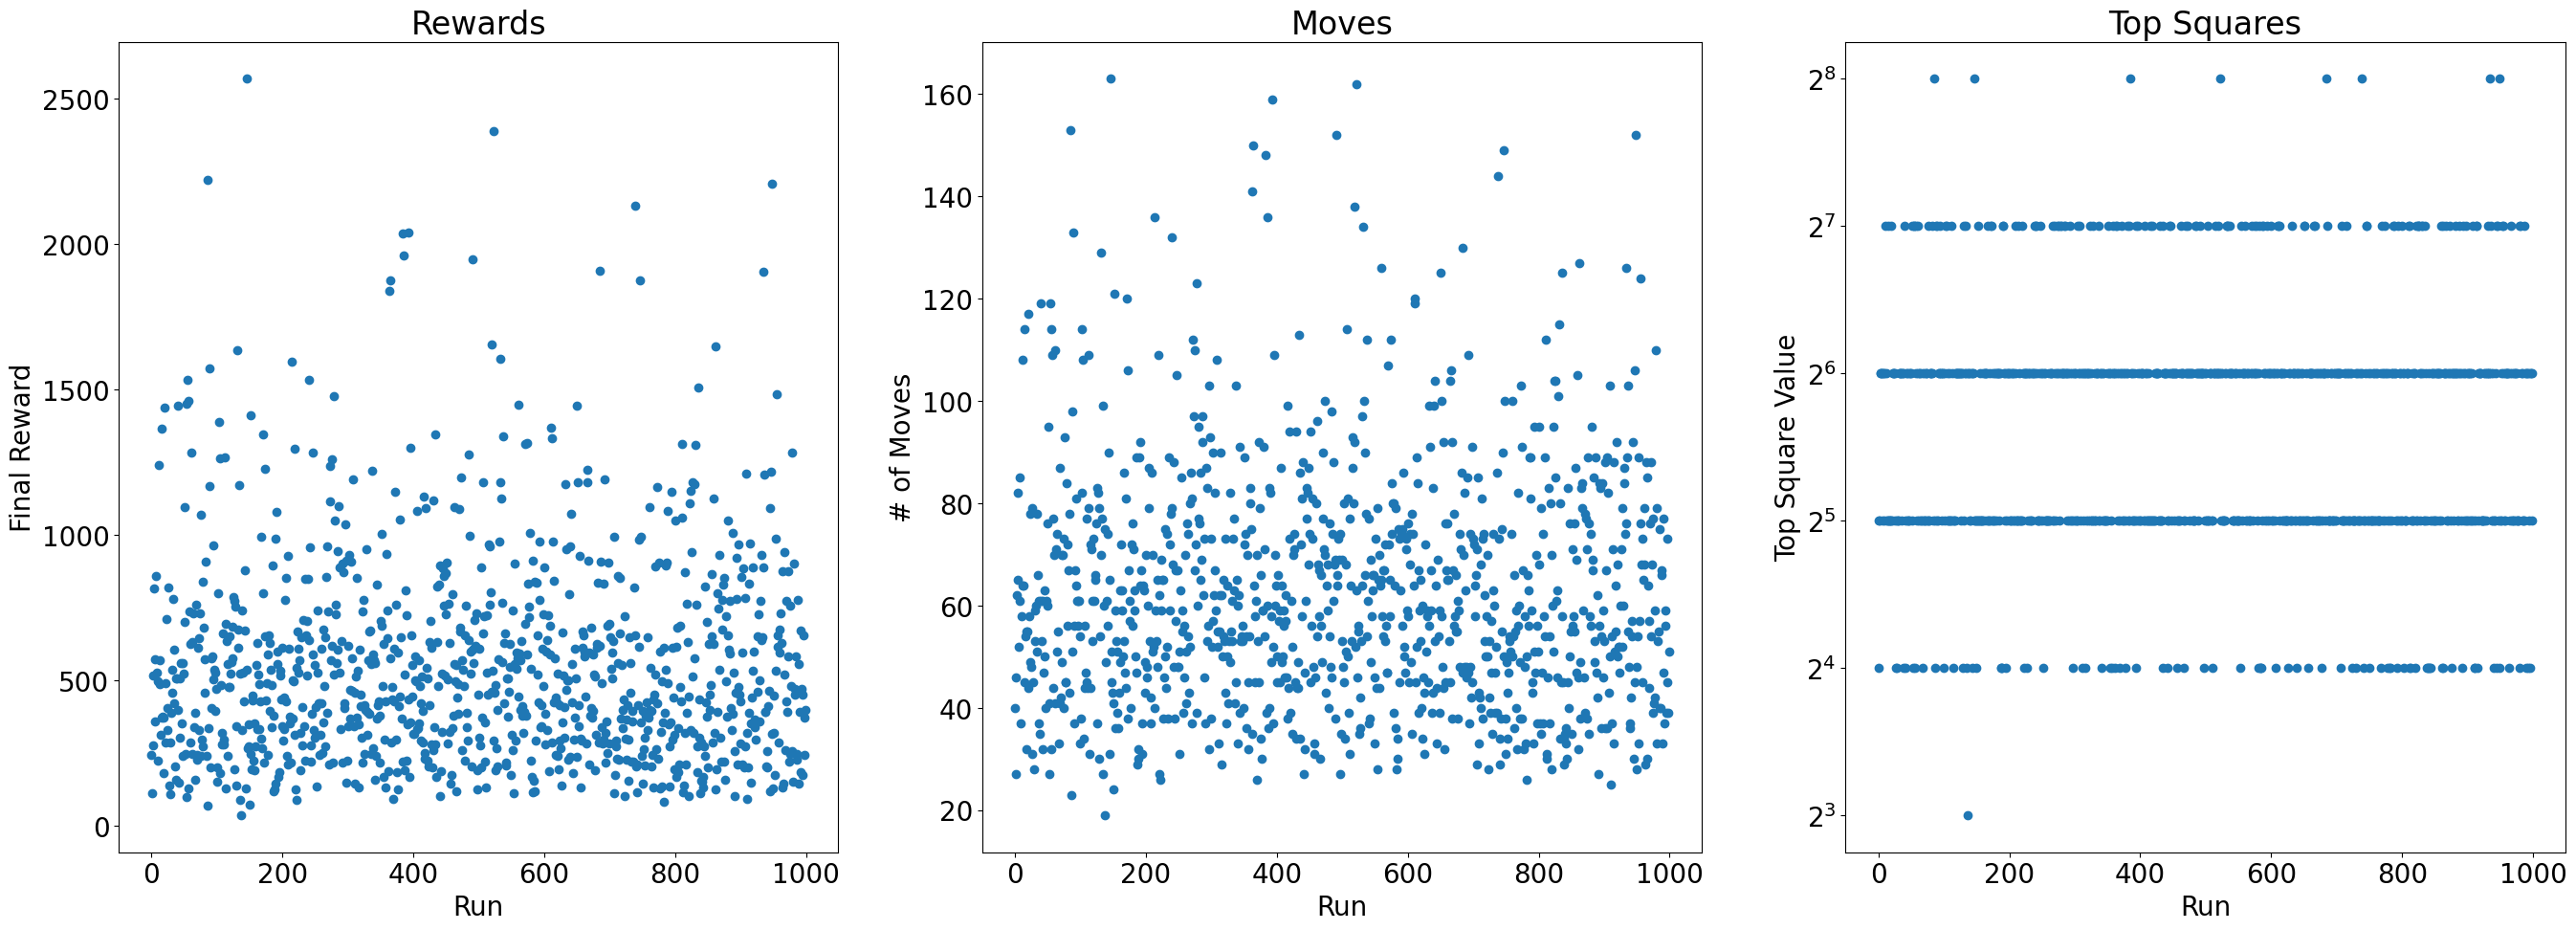

In [112]:
plot_results(simple_rewards, simple_top_square, simple_moves)

In [113]:
simple_summary = summarize_results(simple_rewards, simple_top_square, simple_moves)
format_results(simple_summary)

Rewards
---------------
Mean | 558.968
STD  | 362.1088330543733
Max  | 2568
Min  | 36
---------------

Moves
---------------
Mean | 62.918
STD  | 23.781111748612595
Max  | 163
Min  | 19
---------------

Top Squares
---------------
Min  | 8
Max  | 256
Counts:
	    8 | 1
	   16 | 82
	   32 | 358
	   64 | 417
	  128 | 134
	  256 | 8


# Every DQN

Trained by feeding in reward associated with up/down/left/right for each state in 1 step for 10000 episodes

In [114]:
every_rewards, every_top_square, every_moves = play_game("../trained_models/everyDQN10000", training_every_action.SimpleDQN, runs = 1000)


Runs: 100%|██████████| 1000/1000 [00:44<00:00, 22.41it/s]


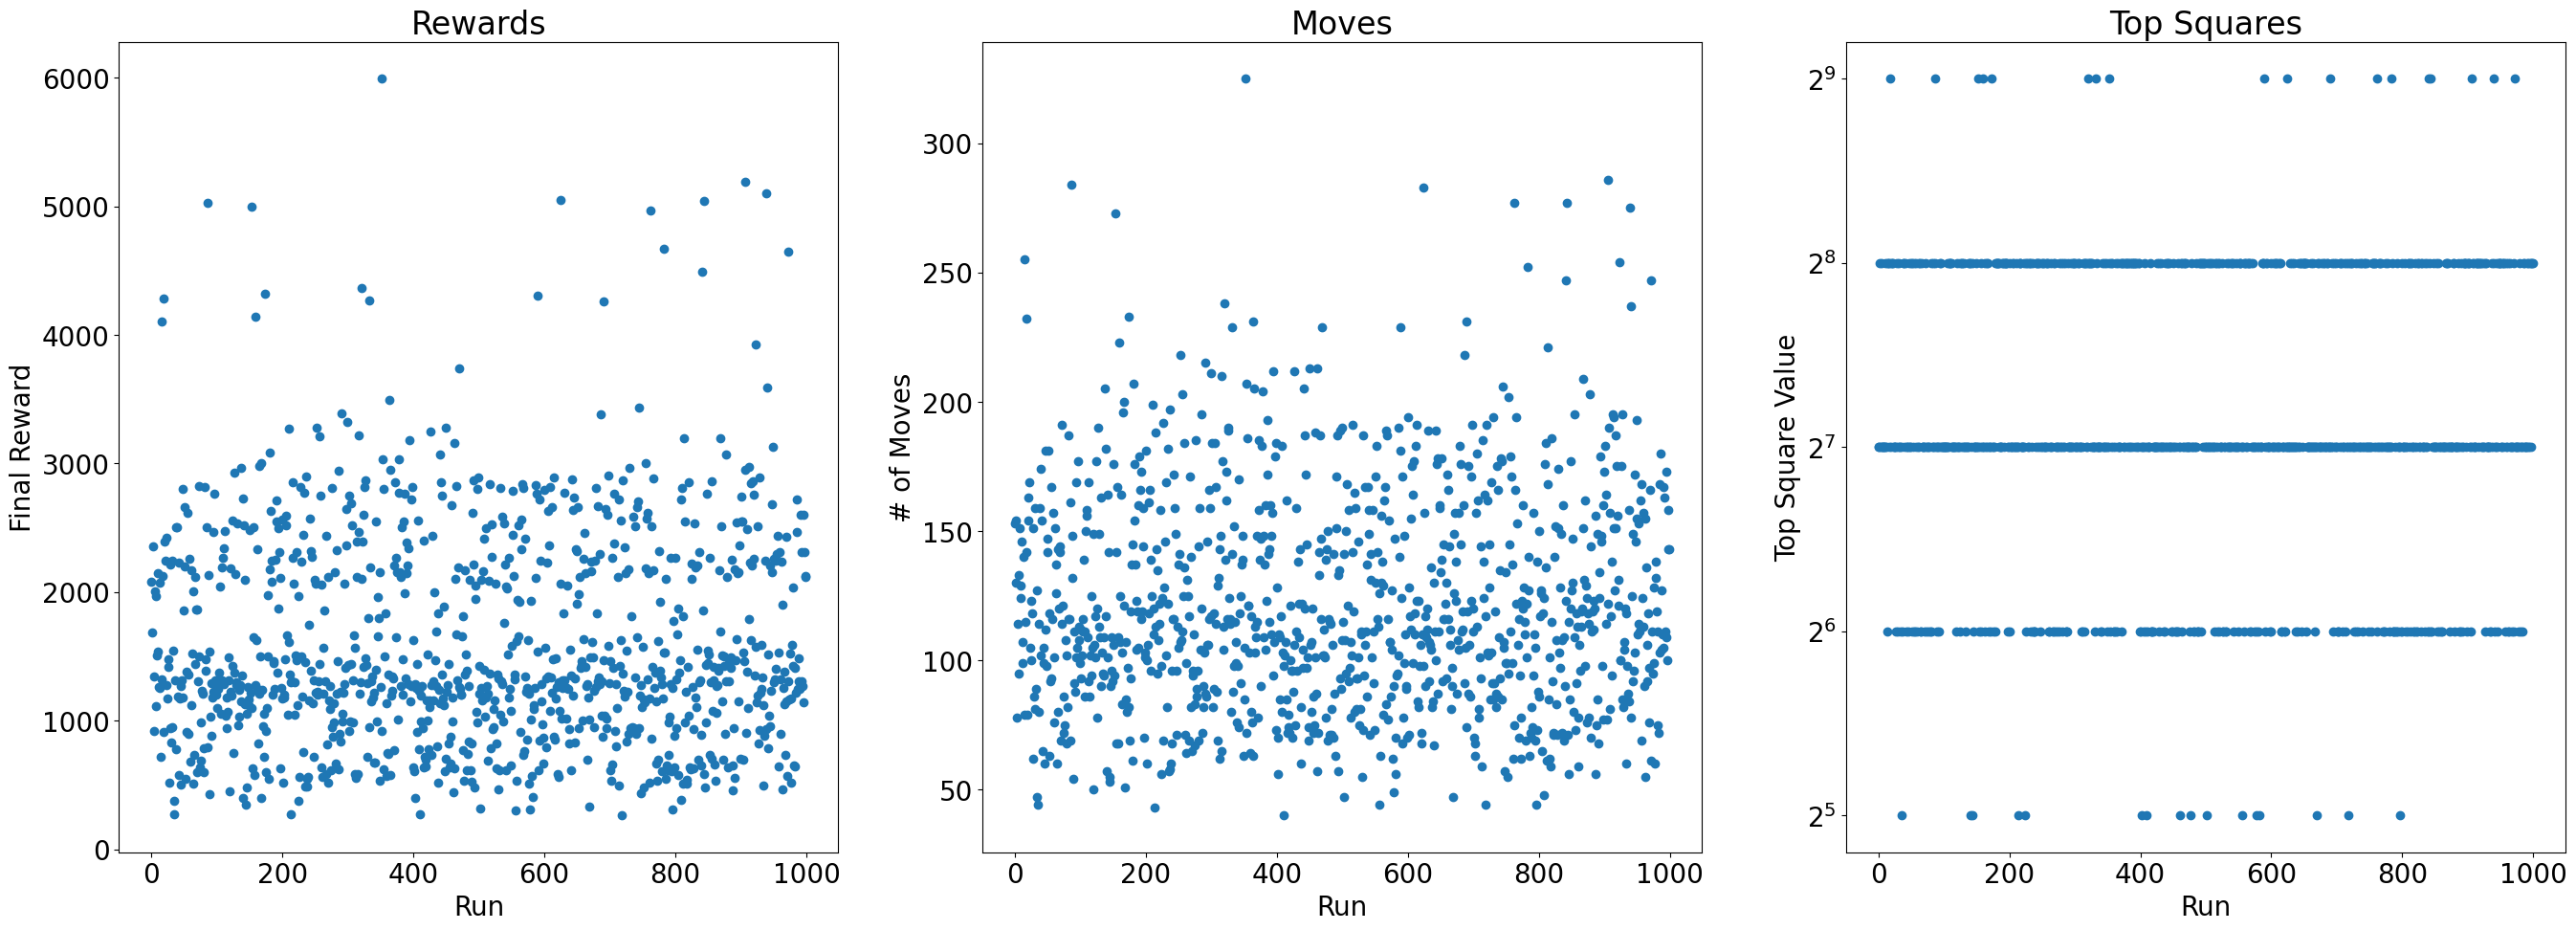

In [115]:
plot_results(every_rewards, every_top_square, every_moves)

In [116]:
every_summary = summarize_results(every_rewards, every_top_square, every_moves)
format_results(every_summary)

Rewards
---------------
Mean | 1607.52
STD  | 853.0296463781315
Max  | 5992
Min  | 264
---------------

Moves
---------------
Mean | 122.419
STD  | 43.37159714605862
Max  | 325
Min  | 40
---------------

Top Squares
---------------
Min  | 32
Max  | 512
Counts:
	   32 | 16
	   64 | 179
	  128 | 470
	  256 | 317
	  512 | 18


100000 episodes

In [107]:
every_rewards_2, every_top_square_2, every_moves_2 = play_game("../trained_models/everyDQN100000", training_every_action.SimpleDQN, runs = 1000)


Runs: 100%|██████████| 1000/1000 [01:33<00:00, 10.65it/s]


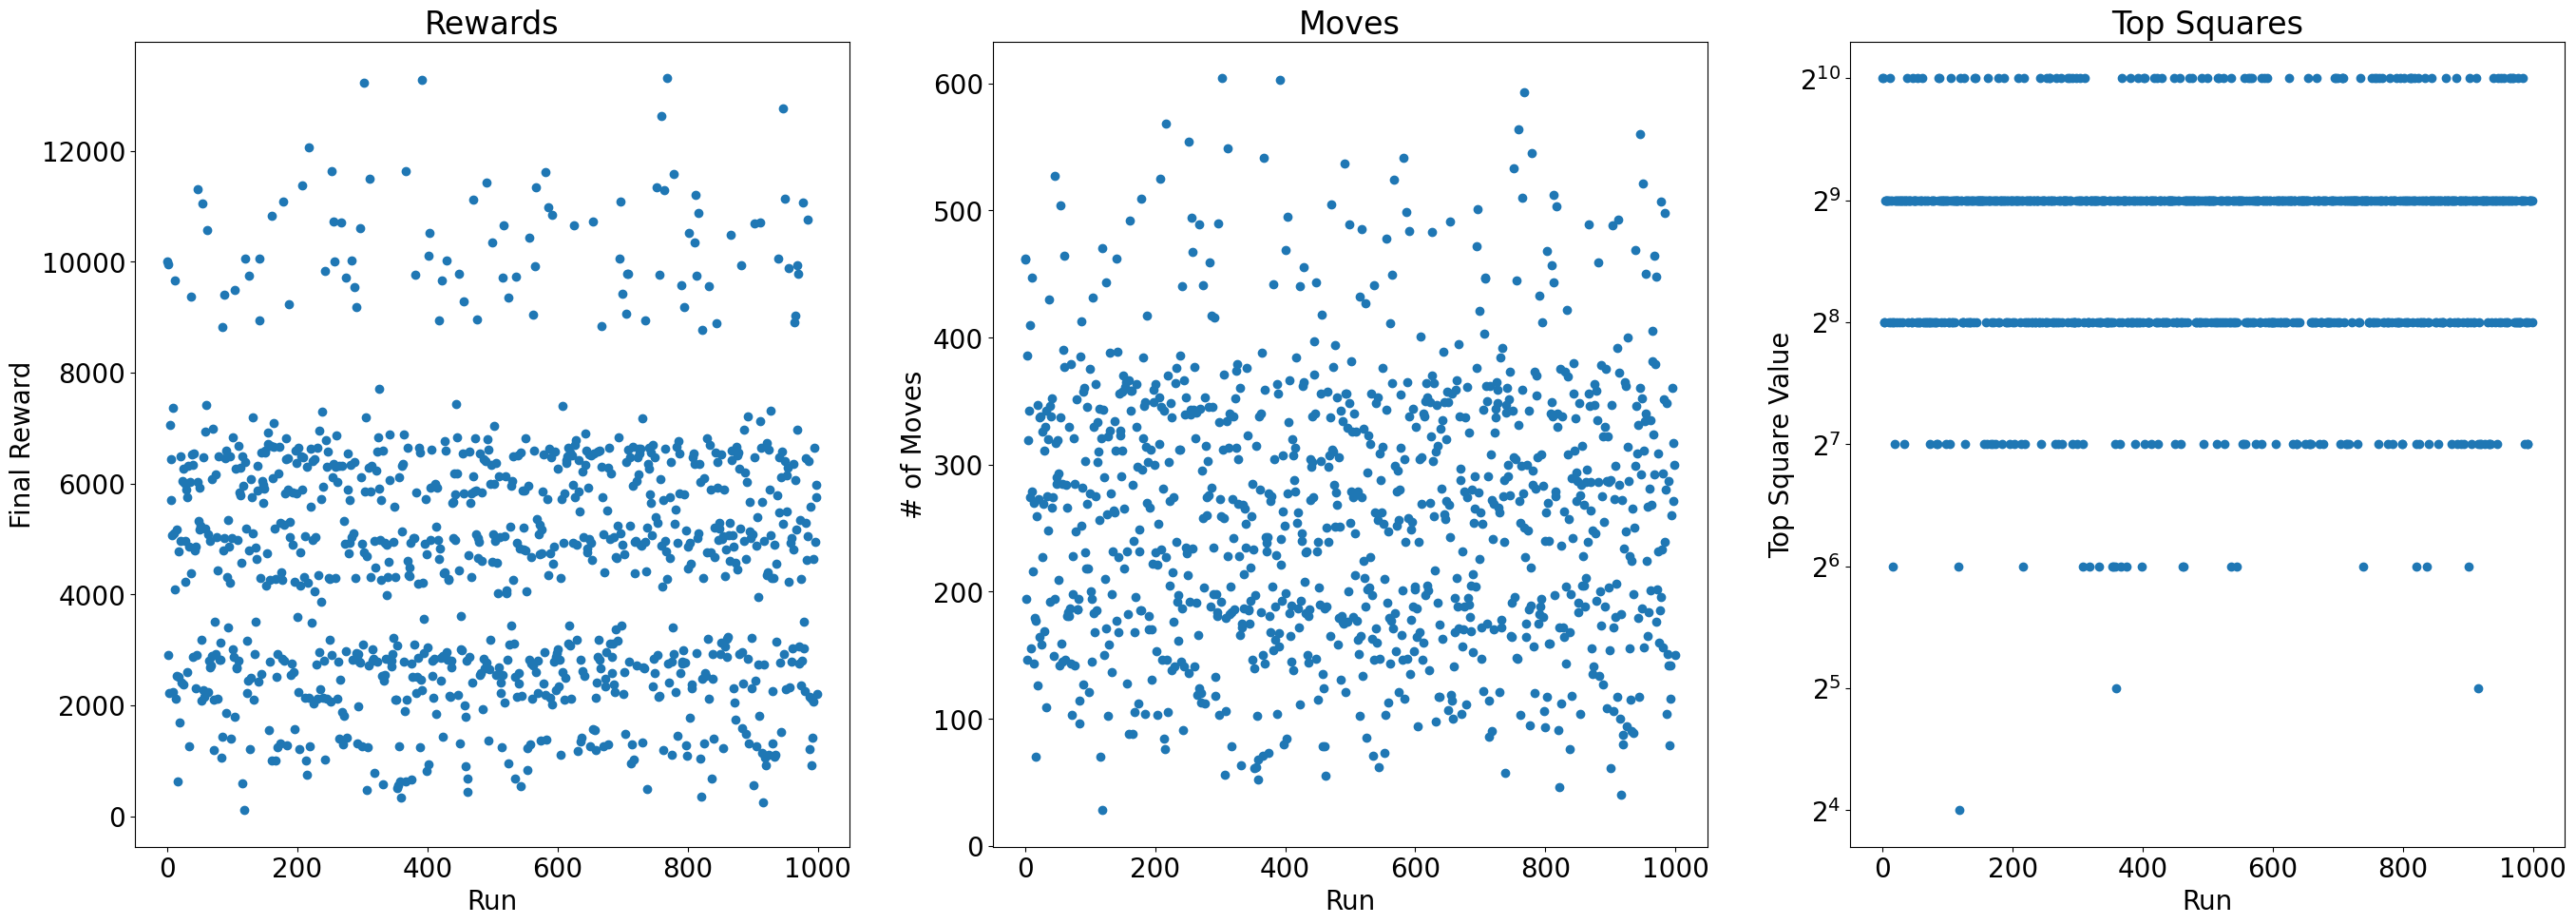

In [108]:
plot_results(every_rewards_2, every_top_square_2, every_moves_2)

In [110]:
every_summary_2 = summarize_results(every_rewards_2, every_top_square_2, every_moves_2)
format_results(every_summary_2)

Rewards
---------------
Mean | 4785.092
STD  | 2552.940567960014
Max  | 13308
Min  | 108
---------------

Moves
---------------
Mean | 263.325
STD  | 107.5152797280461
Max  | 604
Min  | 28
---------------

Top Squares
---------------
Min  | 16
Max  | 1024
Counts:
	   16 | 1
	   32 | 2
	   64 | 20
	  128 | 81
	  256 | 276
	  512 | 524
	 1024 | 96
